In [28]:
import numpy as np



# a_sequences = prepare_sequences(r'C:\Users\oem\Desktop\jhy\dataset2\(It is impossible)\raw_1707385020.npy')



In [3]:
### test
def prepare_sequences(file_path, sequence_length=30):
    data = np.load(file_path, allow_pickle=True).astype(np.float16)
    sequences = []
    for i in range(len(data) - sequence_length ):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    sequences = np.array(sequences)

    return sequences
import numpy as np
import os
import glob
from tensorflow.python.client import device_lib
import tensorflow as tf
# print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import numpy as np
from tqdm import tqdm
import os
import glob  # glob 라이브러리 추가
import pickle
from tensorflow.keras.utils import to_categorical
from datetime import datetime
import random

start_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print(start_time)
os.makedirs(f'C:/Users/oem/Desktop/jhy/array/{start_time}',exist_ok=True)

# dataset 폴더 경로 설정
# PATH = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'
PATH = r'C:/Users/oem/Desktop/jhy/dataset'

# dataset 폴더 아래의 모든 폴더 목록을 얻기
actions = []  # 변경된 부분
label_mapping = {}  # 변경된 부분

### 액션 리스트 확인
for folder in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, folder)):
        # 각 폴더에 있는 npy 파일들을 확인
        npy_files = glob.glob(os.path.join(PATH, folder, 'raw_*.npy'))
        # 특정 조건에 맞는 npy 파일이 존재하면 actions와 label_mapping에 추가
        if npy_files:
            actions.append(folder)
            label_mapping[folder] = len(actions) - 1
print(len(actions),'are ready')

# 리스트를 파일로 저장
with open(r'C:/Users/oem/Desktop/jhy/signlanguage/Sign_Language_Remaster/logs/act_list.pkl', 'wb') as f:
    pickle.dump(actions, f)



################################################################################################################################

def create_groups(data_count, group_size, appearances_per_data):
    # 데이터셋 초기화
    datasets = list(range(0, data_count ))
    random.shuffle(datasets)

    # 각 데이터의 사용 횟수를 추적하는 딕셔너리
    usage_count = {dataset: 0 for dataset in datasets}
   
    # 그룹을 저장할 리스트
    groups = []
   
    # 현재 그룹
    current_group = []
   
    # 데이터셋을 순환하면서 그룹 생성
    for _ in range(appearances_per_data):
        for dataset in datasets:
            # 현재 그룹에 데이터 추가
            current_group.append(dataset)
            usage_count[dataset] += 1
           
            # 현재 그룹이 가득 찼거나 모든 데이터가 사용된 경우 그룹 저장 및 초기화
            if len(current_group) == group_size or all(usage_count[dataset] == appearances_per_data for dataset in datasets):
                groups.append(current_group)
                current_group = []
   
    return groups

# 4000개의 데이터셋으로 크기가 500인 그룹을 만들고, 각 데이터가 3번씩 포함되도록 그룹 생성
groups = create_groups(len(actions), 300, 3)
print(len(groups),'개 그룹이 만들어질 예정입니다.')
for group_idx, group in tqdm(enumerate(groups)):
    data = []
    labels = []
    # print(len(group))
    for act_idx in group:
        # print(act_idx)
        action = actions[act_idx]
    
################################################################################################################################
        PATH2 = os.path.join(PATH, action) #/dataset/{action}
        file_path = glob.glob(os.path.join(PATH2, f'raw_*.npy'))[0]
        try:
            loaded_data = prepare_sequences(file_path)  # raw 데이터를 seq화 함
            # loaded_data = np.load(file_path, allow_pickle=True).astype(np.float16)
            data.append(loaded_data)
################################################################################################################################

            label = np.full((loaded_data.shape[0],), label_mapping[action])
            labels.append(label)
        except FileNotFoundError:
            print(f"File not found for action: {action}")

    x_data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    y_data = to_categorical(labels, num_classes=len(actions))

    np.savez_compressed(f'C:/Users/oem/Desktop/jhy/array/{start_time}/{group_idx}_XData',x_data)
    np.savez_compressed(f'C:/Users/oem/Desktop/jhy/array/{start_time}/{group_idx}_YData',y_data)

Num GPUs Available:  4
2024-02-26_09-20-51
1645 are ready
33 개 그룹이 만들어질 예정입니다.


33it [18:15, 33.19s/it]


In [5]:
!python --version



Python 3.10.13


# 여기서 부터 학습

In [1]:
# 저장파일 불러오기
import numpy as np
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from datetime import datetime

with open('C:/Users/oem/Desktop/jhy/signlanguage/Sign_Language_Remaster/logs/act_list.pkl', 'rb') as file:
    # 리스트 로드
    actions = pickle.load(file)
    print(len(actions),'개의 액션이 저장되어있습니다.')

#model 1

#모델 생성
model = Sequential([
    LSTM(512, activation='tanh', input_shape=(30,156)),
    # LSTM(512, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(len(actions), activation='softmax') #### @주의 모델별로 actions내용을 다르게 잡아주는게 좋을지도..?
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


1645 개의 액션이 저장되어있습니다.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1370112   
                                                                 
 dense (Dense)               (None, 1645)              843885    
                                                                 
Total params: 2,213,997
Trainable params: 2,213,997
Non-trainable params: 0
_________________________________________________________________


  0%|          | 0/4 [00:00<?, ?it/s]

21 / 25
x_train shape: (228992, 30, 156)
y_train shape: (228992, 1645)
model21 saved!


 25%|██▌       | 1/4 [26:42<1:20:08, 1602.68s/it]

22 / 25
x_train shape: (235782, 30, 156)
y_train shape: (235782, 1645)
model22 saved!


 50%|█████     | 2/4 [1:02:57<1:04:38, 1939.16s/it]

23 / 25
x_train shape: (232546, 30, 156)
y_train shape: (232546, 1645)
model23 saved!


 75%|███████▌  | 3/4 [1:42:03<35:24, 2124.81s/it]  

24 / 25
x_train shape: (153604, 30, 156)
y_train shape: (153604, 1645)
model24 saved!


100%|██████████| 4/4 [2:09:03<00:00, 1935.97s/it]


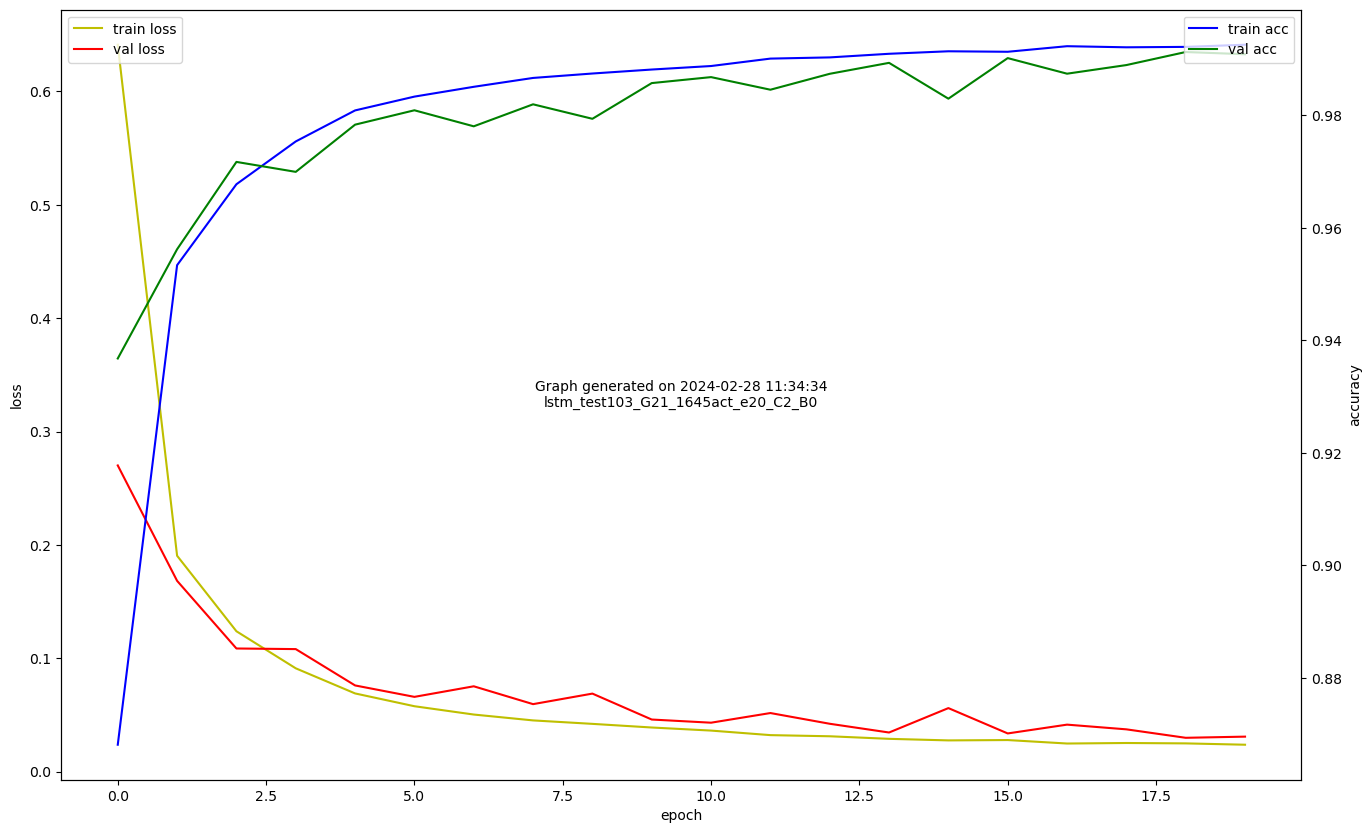

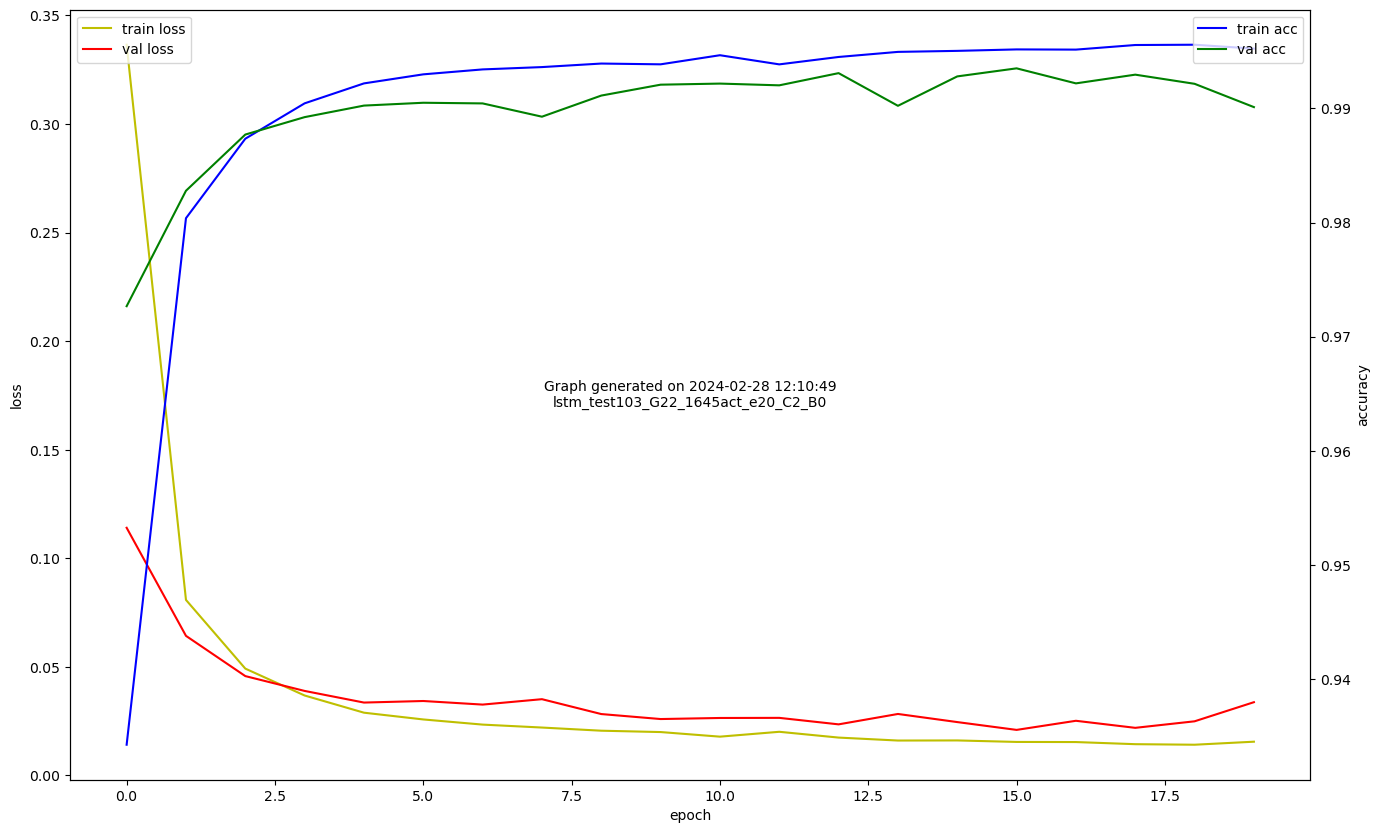

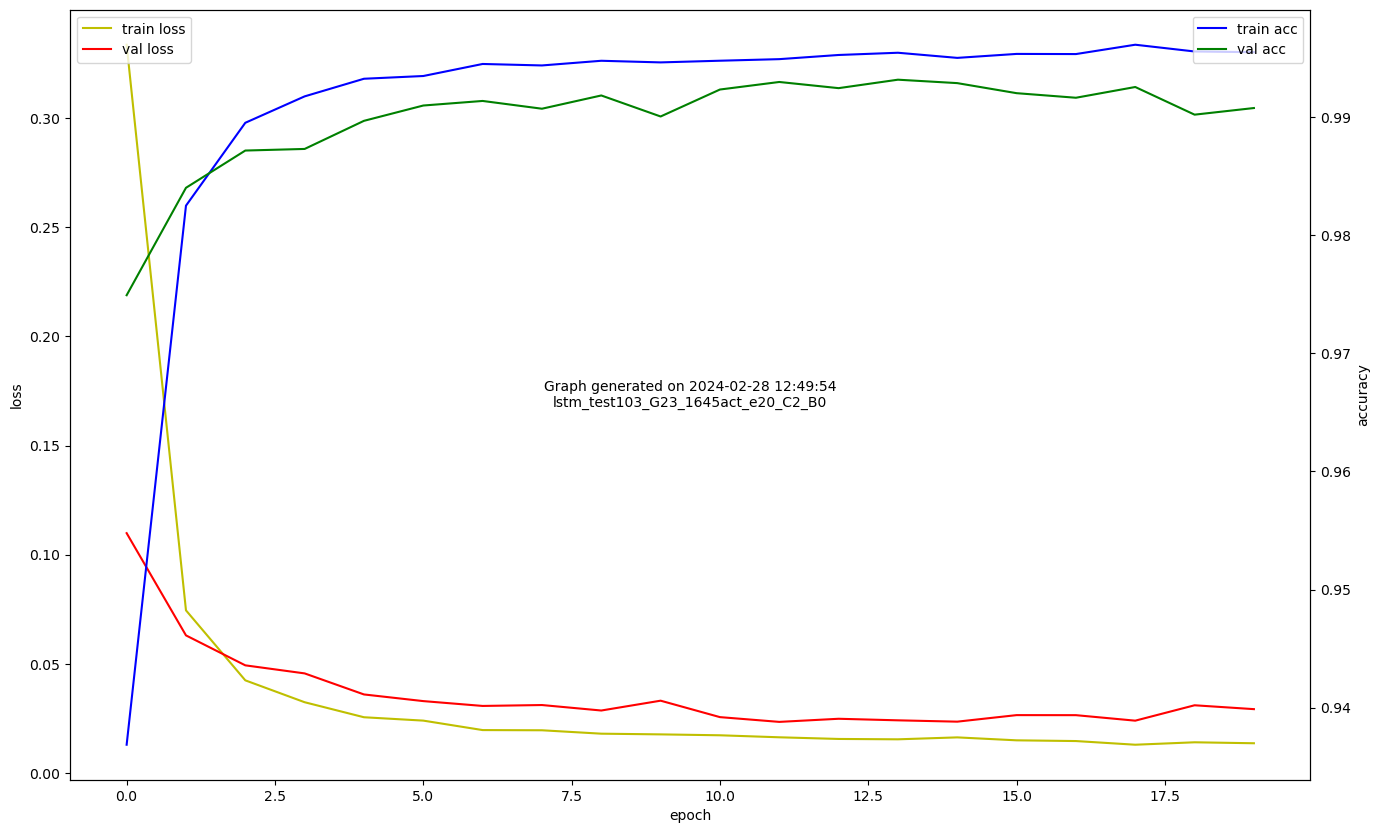

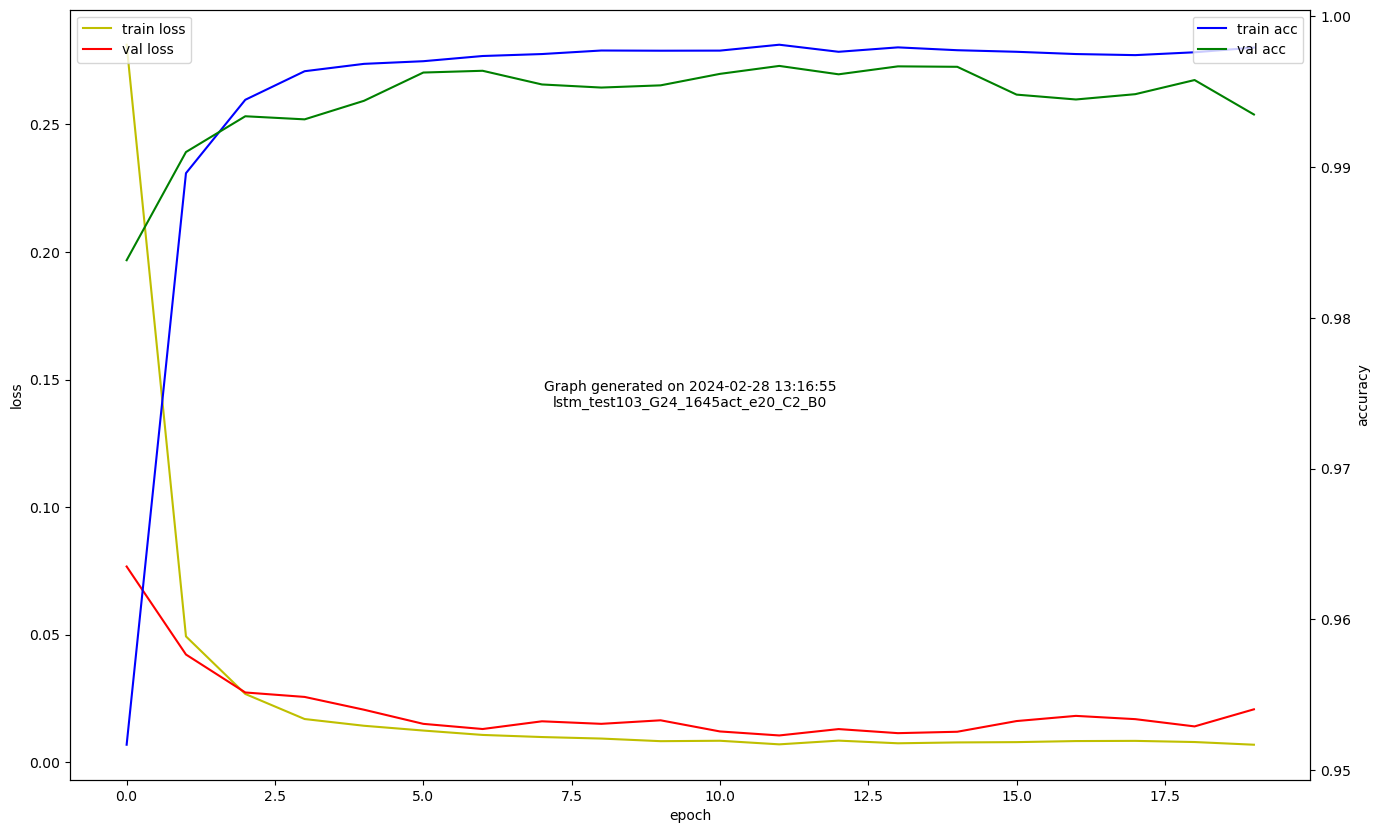

In [2]:
VERSION = 103
EPOCHS = 20
BATCH_SIZE = 0
DATA_CUT = 2
SUB_PATH = '2024-02-25_23-26-15'
# 모델이 저장될 폴더 생성
folder_path = f'C:/Users/oem/Desktop/jhy/signlanguage/Sign_Language_Remaster/model/{SUB_PATH}'
os.makedirs(folder_path, exist_ok=True)

# 하위 파일 수 확인
items = os.listdir(f'C:/Users/oem/Desktop/jhy/array/{SUB_PATH}')
file_count = sum(1 for item in items if os.path.isfile(os.path.join(f'C:/Users/oem/Desktop/jhy/array/{SUB_PATH}', item)))
# print()

for i in tqdm(range(21,int(file_count/2))):
    print(i,'/',int(file_count/2))
    x_data = np.load(f'C:/Users/oem/Desktop/jhy/array/{SUB_PATH}/{i}_XData.npz')
    y_data = np.load(f'C:/Users/oem/Desktop/jhy/array/{SUB_PATH}/{i}_YData.npz')
    x_data = x_data['arr_0']
    y_data = y_data['arr_0']
    # data를 train과 test로 나눔
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

    # 데이터 자르기
    if DATA_CUT:
        x_train = x_train[::DATA_CUT]
        y_train = y_train[::DATA_CUT]
        # x_test = x_test[::DATA_CUT]
        # y_test = y_test[::DATA_CUT]
    # x_train, x_test, y_train, y_test의 크기 확인
    print(f"x_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    # print(f"x_test shape: {x_test.shape}")
    # print(f"y_test shape: {y_test.shape}")
    # import sys

    # print('x_train size :',sys.getsizeof(x_train))
    # print('y_train size :',sys.getsizeof(y_train))

    # 메모리 정리
    x_data, y_data = 0,0

    # 모델 학습
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        # batch_size=BATCH_SIZE,
        shuffle = False,
        verbose=0,
        # callbacks=[
        #     ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        #     ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
        # ]
    )
    # VERSION = 43
    MODEL_NAME = f'lstm_test{VERSION}_G{i}_{len(actions)}act_e{EPOCHS}_C{DATA_CUT}_B{BATCH_SIZE}'
    model.save(f'C:/Users/oem/Desktop/jhy/signlanguage/Sign_Language_Remaster/model/{SUB_PATH}/{MODEL_NAME}.h5')
    print(f'model{i} saved!')



    # 학습그래프 생성 및 저장
    fig, loss_ax = plt.subplots(figsize=(16, 10))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['acc'], 'b', label='train acc')
    acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')


    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    plt.text(0.5, 0.5, f"Graph generated on {current_time}\n{MODEL_NAME}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig(f'{MODEL_NAME}.png')
    # plt.show()